In [1]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import os.path
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'
plt.rcParams['image.cmap'] = 'RdBu'

from progress_bar import *
from useful import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'

exps = ['exp1_HS1','exp2_hc1.0','exp2_hc10.0','exp2_hc50.0','exp2_hc200.0']

In [2]:
exp = 'exp9v1_hc10.0-obl0.0'
ds = open_climatology(data_dir, exp)


itcz_lat = []
for i in range(ds.pentad.size):
    itcz_lat.append(calc_itcz_lat(ds.isel(pentad=i), do_plot=0))
    
    

No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan


In [3]:
np.nansum(itcz_lat)

-248.70364832481943

In [2]:
# --- Look at HC strength and itcz_lat for each obliquity ---

exps = []

hcs = [10]
obls = np.arange(0,91,15)
#obls = [15]

hc_strength = []
itcz_lat = []

for hc in hcs:
    for obl in obls:
        exps += ['exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl)]
        
        
for i, exp in enumerate(exps):
    ds = open_climatology(data_dir, exp)
    #ds.coords['season'] = (((ds.quintad+ds.quintad.size/8)//(ds.quintad.size/4))%4).astype(int)
    #ds = ds.groupby('season').mean('quintad')
    #ds.rename({'season':'quintad'}, inplace=True)
    hc_strength.append([])
    itcz_lat.append([])
    for j in range(ds.pentad.size):
        dss = ds.isel(pentad=j).sel(pfull=500, method='nearest')
        hc_strength[i].append(np.max(np.abs(dss.psi.values)))
        itcz_lat[i].append(calc_itcz_lat(ds.isel(pentad=j)))
        

No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan


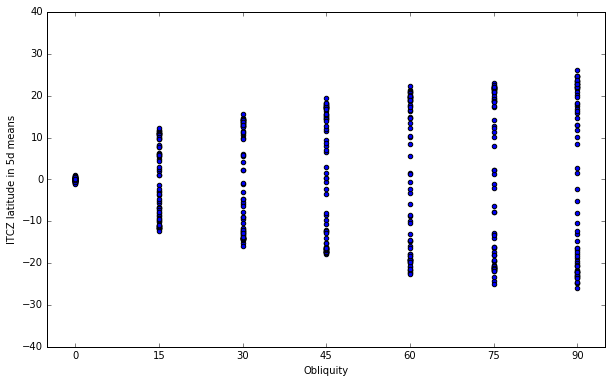

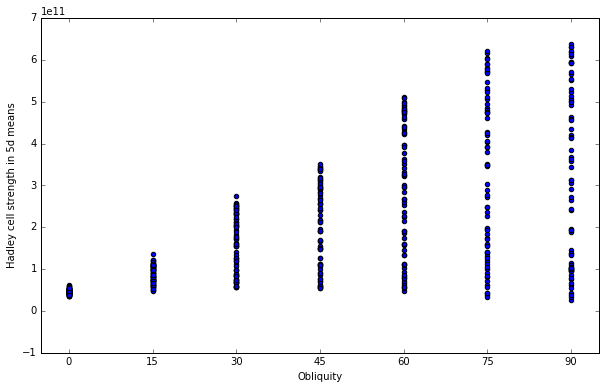

In [7]:
# --- plots for hc stength and itcz lat
fig, ax = plt.subplots(figsize=(10,6))
for xe, ye in zip(obls, itcz_lat):
    ax.scatter([xe]*len(ye), ye)
    
ax.set_xticks(np.arange(0,91,15))
ax.set_xlim([-5,95])
ax.set_ylim([-40,40])
ax.set_xlabel('Obliquity')
ax.set_ylabel('ITCZ latitude in 5d means')

fig, ax = plt.subplots(figsize=(10,6))
for xe, ye in zip(obls, hc_strength):
    ax.scatter([xe]*len(ye), ye)
    
ax.set_xticks(np.arange(0,91,15))
ax.set_xlim([-5,95])
#ax.set_ylim([-40,40])
ax.set_xlabel('Obliquity')
ax.set_ylabel('Hadley cell strength in 5d means')

In [29]:
print hc_strength

[[41691325367.148911, 39953732179.812462, 38241050203.919281, 40911961236.083694], [87090349782.743469, 75274103537.274765, 88244526728.815445, 76273006060.974274], [173635683541.22379, 126795577699.10934, 175710923827.49524, 130763739919.86697], [237619330828.38834, 159195588211.53842, 239428741233.13614, 159492344512.63098], [329611909612.09979, 225248698039.0773, 328964136288.01691, 224317920356.3551], [398178386145.73694, 230158521297.64948, 395802193606.61285, 230560640832.78015], [410374855221.29382, 207081996517.27414, 412875383780.94006, 206450125945.59634]]


In [128]:
def calc_heldhou(ds, rot=7.3e-5):
    
    r_cp = 0.286
    itcz = calc_itcz_lat(ds)
    if not np.isnan(itcz):
        trop_h = ds.h_trop_calc.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat').values
        trop_p = ds.p_trop_calc.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat').values
        ds = calc_pot_temp(ds)
        ds = ds.isel(pfull=-1)
        del_h_S = ((ds.pot_temp.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat')-
                   ds.pot_temp.sel(lat=np.arange(-88,-68,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat'))/
                   ds.pot_temp.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat')).values
        del_h_N = ((ds.pot_temp.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat')-
                   ds.pot_temp.sel(lat=np.arange(68,88,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat'))/
             ds.pot_temp.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]), method='nearest').mean('lat')).values
    
        del_h = np.array((del_h_S, del_h_N))
        R = (9.81*trop_h*1e3*del_h)/((rot)**2 * (6371e3)**2)
        return np.rad2deg((5/3 * R)**0.5)
    else:
        return (np.nan, np.nan)
    

In [129]:
exp = 'exp9v1_hc10.0-obl15.0'
t = 60
ds = open_climatology(data_dir, exp)

ds = ds.isel(pentad=t)

calc_heldhou(ds)


array([ 16.64309254,  24.31310128])

20 loops, best of 3: 12 ms per loop


-31.731396843711607

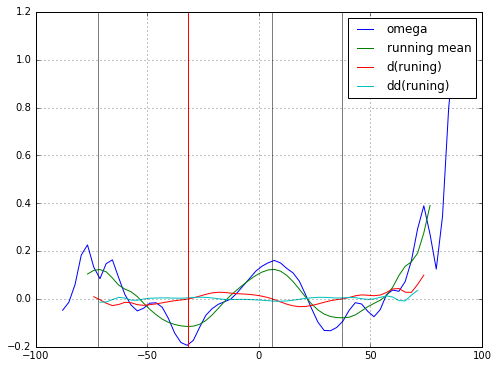

In [31]:
dss = ds.isel(season=14)
%timeit -n 20 calc_descending_branch(dss)


calc_descending_branch(dss, do_plot=True)

In [151]:
# --- Compare theoretical (Held Hou) Hadley cell with model size/strength ---

exps = []
time_flag = 1

hcs = [10]
obls = np.arange(0,61,15)
#obls = [15]

for hc in hcs:
    for obl in obls:
        exps += ['exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl)]
        
hh = np.zeros([len(exps), 72, 2])
hh_width = np.zeros([len(exps), 72, 2])
hc = np.zeros([len(exps), 72, 2])
psi_edge = np.zeros([len(exps), 72, 3])
width = np.zeros([len(exps), 72, 2])
        
for j, exp in enumerate(exps):
    ds = open_climatology(data_dir,exp)
            
    if time_flag == 1:
        
        #ds.coords['season'] = (((ds.pentad+ds.pentad.size/8)//(ds.pentad.size/4))%4).astype(int)
        #ds = ds.groupby('season').mean('pentad')
        
        for i in range(ds.pentad.size):
            dss = ds.isel(pentad=i)
            
            hh_width[j, i, :] = calc_heldhou(dss)            
            threshold = 0.1*np.max(np.abs(dss.psi.values))
            #hc_edges = calc_hc_edges(dss, threshold=threshold)
            #psi_edge[j, i, :] = hc_edges
            up = calc_itcz_lat(dss)
            down = calc_descending_branch(dss)
            #width[j, i, :] = [up - hc_edges[0], hc_edges[2] - up]
            hc[j, i, :] = [up, down]
            hh[j, i, :] = [up-hh_width[j,i,0], up+hh_width[j,i,1]]

    

No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan
No ITCZ found, returning nan


(-1, 72)

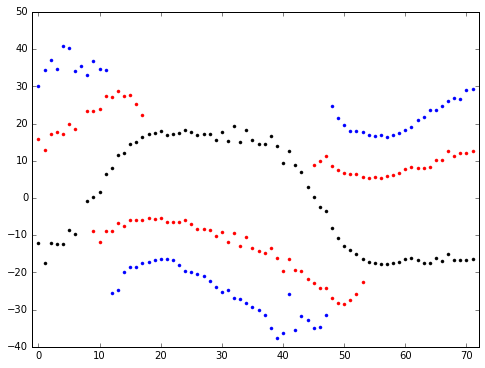

In [157]:
# --- make nice plots with the above theoretical data ---

# how well the predictions hold pentad by pentad for each exp set
# work in progress

fig, ax = plt.subplots()
i = 3
t = np.arange(72)
ax.plot(t, hc[i,:,0], 'k.', t, hc[i,:,1], 'b.')
ax.plot(t, hh[i,:,0], 'r.', t, hh[i,:,1], 'r.')
#ax.plot(t, psi_edge[i,:,0], 'g', t, psi_edge[i,:,1], 'g', t, psi_edge[i,:,2], 'g')
ax.set_xlim([-1,72])

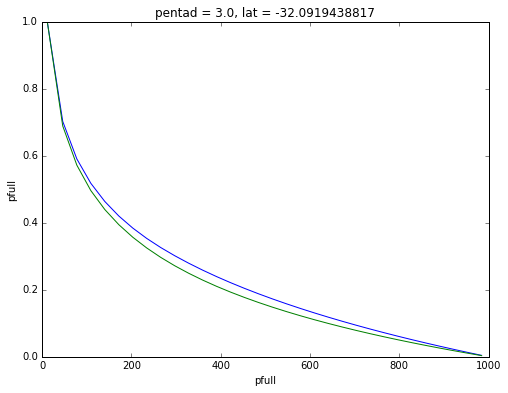

In [41]:
ds = open_climatology(data_dir, 'exp9v1_hc30.0-obl30.0')

#print ds
da = ds.isel(pentad=3, lat=20)

pressure = np.log(1000/da.pfull)/np.max(np.log(1000/da.pfull.values))
height = da.height/np.max(da.height.values)

height.plot()
pressure.plot()


#da.height.plot()



In [32]:
287*240/9.81*np.log(1000/109)

15562.297807170864

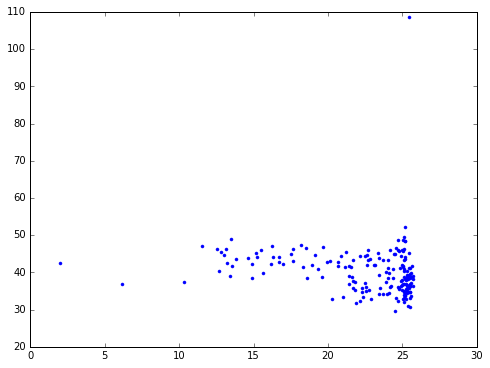

In [11]:
plt.plot(HH_cell, cell2, '.')

In [ ]:
# --- Attempting to produce plots similar to Ruth's of log(ITCZ lat) v log(500hpa psi)
#     over 5d means for some experiment ---

exp = 'exp9v1_hc30.0-obl30.0'
#exp = 'exp5_obl60.0'

ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))

lag = calc_seasonal_lag(ds.teq)

if np.isnan(lag):
    lag = 0

ds.coords['day'] = (ds.day-lag+45)%360
ds.coords['season'] = np.floor(ds.day/90)
ds.coords['d5'] = np.floor(ds.day/5)

ds = ds.groupby('d5').mean('time')

itcz = np.zeros(len(ds.d5))
itcz_new = np.zeros(len(ds.d5))
strength = np.zeros(len(ds.d5))

for i in range(len(ds.d5)):
    data = ds.isel(d5=i)
    #print('5d %d' %i)    
    #edges = get_hc_edges(data)
    #print(edges)
    threshold = threshold = 0.2*np.max(np.abs(data.psi.sel(pfull=500,method='nearest').values))
    edges = get_hc_edges(data, method='psi',threshold=threshold)
    
    #print(edges)
    #print('-----')
    itcz[i] = np.abs(edges[1])
    itcz_new[i] = calc_itcz_lat(data)
    strength[i] = np.abs(data.psi).sel(pfull=500,method='nearest').max().values


#plot stuff is good
eq = np.append(np.arange(0,18), np.arange(36,54))
sw = np.append(np.arange(18,36), np.arange(54,72))
d = np.arange(0,72)
cax = np.cos((d-8)*2*np.pi/36)
a = np.repeat(0, 9)
a = np.append(a, np.repeat(1, 18))
a = np.append(a, np.repeat(0, 9))
marks = np.append(a, a)

a = np.repeat(0, 27)
a = np.append(a, np.repeat(1, 36))
#marks = np.append(a, np.repeat(0, 9))

fig, ax = plt.subplots()
#ax.plot(itcz[eq], strength[eq], 'bo', label='Equinox')
#ax.plot(itcz[sw], strength[sw], 'ro', label='Winter')
f = ax.scatter(itcz[marks==0], strength[marks==0], c=cax[marks==0],
               marker='o', s=40)#, label='Equatorward')
f2 = ax.scatter(itcz[marks==1], strength[marks==1], c=cax[marks==1],
               marker='^', s=40)#, label='Poleward')

c1 = ax.plot((0,1),(0,0), color='b', marker='s', linestyle='', label='Spring & Autumn')
c2 = ax.plot((0,1),(0,0), color='r', marker='s', linestyle='', label='Summer & Winter')
c1 = ax.plot((0,1),(0,0), color='k', marker='o', linestyle='', label='Hotspot equatorward')
c2 = ax.plot((0,1),(0,0), color='k', marker='^', linestyle='', label='Hotspot poleward')

#ax.set_xscale('log')
ax.set_xlim([np.min(itcz)-0.1, np.max(itcz)+0.5*np.max(itcz)])
ax.set_xticks([0.625, 1.25, 2.5, 5, 10, 20, 40])
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_xlim([0,70])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_yscale('log')
ax.set_ylim([np.min(strength)-5e9, np.max(strength)+0.3*np.max(strength)])
ax.set_yticks(np.linspace(np.ceil(ax.get_ylim()[0]/1e10)*1e10, np.floor(ax.get_ylim()[1]/1e10)*1e10, 3))
#ax.set_yticks([2e10, 4e10, 8e10, 16e10])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_title(exp[5:], fontsize=14)
ax.set_xlabel('ITCZ latitude')
ax.set_ylabel('PSI_500')
#fig.colorbar(f)
plt.legend(loc=2, title='', fontsize=8)
plt.grid()




In [ ]:
#plot stuff is good
eq = np.append(np.arange(0,18), np.arange(36,54))
sw = np.append(np.arange(18,36), np.arange(54,72))
d = np.arange(0,72)
cax = np.cos((d-8)*2*np.pi/36)
a = np.repeat(0, 9)
a = np.append(a, np.repeat(1, 18))
a = np.append(a, np.repeat(0, 9))
marks = np.append(a, a)

itcz_new = np.abs(itcz_new)
a = np.repeat(0, 27)
a = np.append(a, np.repeat(1, 36))
#marks = np.append(a, np.repeat(0, 9))

fig, ax = plt.subplots()
#ax.plot(itcz[eq], strength[eq], 'bo', label='Equinox')
#ax.plot(itcz[sw], strength[sw], 'ro', label='Winter')
f = ax.scatter(itcz_new[marks==0], strength[marks==0], c=cax[marks==0],
               marker='o', s=40)#, label='Equatorward')
f2 = ax.scatter(itcz_new[marks==1], strength[marks==1], c=cax[marks==1],
               marker='^', s=40)#, label='Poleward')

c1 = ax.plot((0,1),(0,0), color='b', marker='s', linestyle='', label='Spring & Autumn')
c2 = ax.plot((0,1),(0,0), color='r', marker='s', linestyle='', label='Summer & Winter')
c1 = ax.plot((0,1),(0,0), color='k', marker='o', linestyle='', label='Hotspot equatorward')
c2 = ax.plot((0,1),(0,0), color='k', marker='^', linestyle='', label='Hotspot poleward')

#ax.set_xscale('log')
ax.set_xlim([np.min(itcz_new)-0.1, np.max(itcz_new)+0.5*np.max(itcz_new)])
ax.set_xticks([0.625, 1.25, 2.5, 5, 10, 20, 40])
ax.set_xticks([0, 10, 20, 30])
ax.set_xlim([0,70])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_yscale('log')
ax.set_ylim([np.min(strength)-5e9, np.max(strength)+0.3*np.max(strength)])
ax.set_yticks(np.linspace(np.ceil(ax.get_ylim()[0]/1e10)*1e10, np.floor(ax.get_ylim()[1]/1e10)*1e10, 3))
#ax.set_yticks([2e10, 4e10, 8e10, 16e10])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_title(exp[5:], fontsize=14)
ax.set_xlabel('ITCZ latitude')
ax.set_ylabel('PSI_500')
#fig.colorbar(f)
plt.legend(loc=2, title='', fontsize=8)
plt.grid()

In [ ]:
print itcz_new

In [ ]:
# plot a few days of data on a subplot grid to see changes

exp = 'exp9_hc10.0-obl30.0'
days = [11,12,13,14,15,16]
days = np.arange(14, 24)
days = np.arange(0,18)

if len(days)%2 == 1:
    print('Can"t do odd numbers of days, cutting last one')
    days = days[:-1]

ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))
lag = calc_seasonal_lag(ds.teq)
if np.isnan(lag):
    lag = 0
ds.coords['day'] = (ds.day-lag+45)%360
ds.coords['season'] = np.floor(ds.day/90)
ds.coords['d5'] = np.floor(ds.day/5)
ds = ds.groupby('d5').mean('time')

ds = open_climatology(data_dir, 'exp9v1_hc10.0-obl30.0')
ds.rename({'quintad':'d5'}, inplace=True)

if len(days) == 1:
    fig, axs = plt.subplots(1,1)
else:
    fig, axs = plt.subplots(int(np.ceil(len(days)/2)), 2, figsize=(16,4*int(np.ceil(len(days)/2))), sharex=True, sharey=True)

da = np.abs(ds.psi.isel(d5=days)).sum('d5')/(0.7*(len(days)-1)+1)
vmax = da.max().values
large = np.max(np.abs([da.max().values, da.min().values]))
tl = np.ceil(large/1e10)*1e10
levels = np.linspace(-tl, tl, 16)
    
for i, ax in enumerate(axs.reshape(-1)):
    x = ds.isel(d5=days[i]).lat.values
    y = ds.isel(d5=days[i]).psi.sel(pfull=500,method='nearest')
    xx = np.linspace(min(x), max(x), 500)
    yy = np.interp(xx, x, y)

    y_abs = np.abs(yy)
    t = ds.temp.isel(d5=days[i]).isel(pfull=-1).values
    t_max_lat = ds.isel(d5=days[i]).lat.isel(lat=np.argmax(t))
    
    threshold = 0.2*np.max(y_abs)
    edges = get_hc_edges(ds.isel(d5=days[i]), method='psi', threshold=threshold)
    itcz = calc_itcz_lat(ds.isel(d5=days[i]))
    descend = calc_descending_branch(ds.isel(d5=days[i]))
    
    da = ds.psi.isel(d5=days[i])

    im = da.plot.contourf(x='lat', y='pfull' ,ax=ax, levels=levels, vmax=vmax, add_colorbar=None, extend='both')
    ax.invert_yaxis()
    ax.axhline(500, color='k')
    [ax.axvline(r, color='g', linewidth=2) for r in edges]
    ax.axvline(t_max_lat, linewidth=2, color='r')
    ax.axvline(itcz, linewidth=2, color='m')
    ax.axvline(descend, linewidth=2, color='m')
    ax.text(edges[1]+3, 400, 'ITCZ', rotation=90, color='g')
    ax.set_xticks(np.arange(-60,61,30))
    ax.grid()
    
fig.colorbar(im, ax=axs.ravel().tolist(), ticks=levels)

In [ ]:
## ---- testing hadley cell edge detection ----
exp = 'exp9_hc10.0-obl30.0'
#exp = 'exp5_obl60.0'

ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))
lag = calc_seasonal_lag(ds.teq)
if np.isnan(lag):
    lag = 0
ds.coords['day'] = (ds.day-lag+45)%360
ds.coords['season'] = np.floor(ds.day/90)
ds.coords['d5'] = np.floor(ds.day/5)
ds = ds.groupby('d5').mean('time')

day = 6
threshold = 10e9  #0.1*np.max(abs(y))

x = ds.isel(d5=day).lat.values
y = ds.isel(d5=day).psi.sel(pfull=500,method='nearest')
xx = np.linspace(min(x), max(x), 500)
yy = np.interp(xx, x, y)

y2 = np.abs(yy)
t = ds.temp.isel(d5=day).isel(pfull=-1).values
t_max_lat = ds.isel(d5=day).lat.isel(lat=np.argmax(t))
#ds.psi=np.abs(ds.psi)

threshold = 0.15*np.max(y2)

edges = get_hc_edges(ds.isel(d5=day), method='psi', threshold=threshold)
itcz = calc_itcz_lat(ds.isel(d5=day))
descend = calc_descending_branch(ds.isel(d5=day))

fig, ax2 = plt.subplots(1,1,figsize=(12,6))

ax2.plot(xx,y2,'k')
ax2.axhline(threshold, linewidth=2, color='r')
ax2.text(0, 1.1*threshold, 'Threshold', color='r')
ax2.axvline(t_max_lat, linewidth=3, color='r')
ax2.text(t_max_lat-4, 0.5*np.max(y), 'Temperature max', rotation=90, color='r')
[ax2.axvline(r, color='g', linewidth=2) for r in edges]
[ax2.text(edge-4, 0.5*np.max(y), 'HC edge', rotation=90, color='g') for edge in edges if not np.isnan(edge)]
ax2.text(edges[1]+3, 0.5*np.max(y), 'ITCZ', rotation=90, color='g')
ax2.axvline(itcz, color='m', linewidth=2)
ax2.axvline(descend, color='b', linewidth=2)
ax2.set_title(exp + ' day' + str(day))

wlevel = 1000
ax3 = ax2.twinx()
w = -ds.omega.isel(d5=day).sel(pfull=wlevel, method='nearest')
w = -ds.omega.isel(d5=day).isel(pfull=slice(-16,-1)).sum('pfull')
rho = ds.pfull.sel(pfull=wlevel, method='nearest')/287.058/ds.temp.isel(d5=day).sel(pfull=wlevel, method='nearest')
w = w/rho/9.81
ax3.plot(x,w)

fig, ax = plt.subplots(figsize=(12,8))
ds.psi.isel(d5=day).plot.contourf(x='lat',y='pfull', levels=15)
ax.invert_yaxis()
ax.axhline(500, color='k')
[plt.gca().axvline(r, color='g', linewidth=2) for r in edges]
plt.gca().axvline(t_max_lat, linewidth=2, color='r')

fig, ax = plt.subplots()
ds.temp.isel(d5=day).plot.contourf(x='lat',y='pfull', levels=15)
ax.invert_yaxis()

print(edges)

In [ ]:
def calc_descending_branch(ds, do_plot=False):
    '''Locate the latitude of the descending branch of the Hadley cell using 
    ds.omega, the vertical velocity.
        ds: dataarray with dimensions (pfull, lat)'''
    x = ds.lat.values
    y = (-ds.omega).isel(pfull=slice(-16,-1)).sum('pfull')
   
    roll_y = y.rolling(center=True, lat=5).mean()
    droll_y = roll_y.diff('lat')
    ddroll_y = droll_y.diff('lat')
    roots = calc_roots(droll_y.lat.values, droll_y.values)
    
    vals = []
    for root in roots:
        i = (np.abs(x-root)).argmin()
        vals.append((root, i, float(roll_y.isel(lat=i).values), float(ddroll_y.isel(lat=i).values)))

    # vals is a list of [root, root_index, omega, dd_omega] lists
    vals.sort(key=lambda tup: tup[2], reverse=False)
    print vals

    itcz = 90
    for val in vals:
        if (val[3] > 0) and (np.abs(val[0]) < np.abs(itcz)) and (val[2] < 0.5*vals[0][2]):
            itcz = val[0]
            print('hoping to return {}'.format(itcz))
    if itcz == 90:
        itcz = np.nan
        
    if (do_plot == True):
        fig,ax = plt.subplots()
        plt.plot(x, y, label='omega')
        roll_y.plot(label='rolling_mean')
        droll_y.plot(label='d(rolling)')
        ddroll_y.plot(label='dd(rolling)')
        [ax.axvline(extreme, color='k', linewidth=0.5) for extreme in roots]
        ax.axvline(itcz, color='r', linewidth=1)
        plt.legend(loc=3)
        plt.grid()
        
    if (np.isnan(itcz)):
        print('No ITCZ found, returning nan')
    return itcz


exp = 'exp9v1_hc10.0-obl30.0'

ds = open_climatology(data_dir, exp)

day = 6
itcz_lat = calc_itcz_lat(ds.isel(quintad=day), do_plot=True)
descend_lat = calc_descending_branch(ds.isel(quintad=day), do_plot=True)

fig, ax = plt.subplots()
ax1 = ax.twinx()
ds.psi.isel(quintad=day).plot.contourf(x='lat',y='pfull',levels=14,ax=ax,add_colorbar=None)
ds.temp.isel(quintad=day).plot.contour(x='lat', y='pfull',levels=8,ax=ax1,colors='k',add_colorbar=None)
ax.axvline(itcz_lat, color='m', linewidth=2)
ax.axvline(descend_lat, color='b', linewidth=2)
ax.invert_yaxis()
ax1.invert_yaxis()

In [ ]:
#    (val[3] > 0) and (np.abs(val[0]) < np.abs(itcz)) and (val[2] < 0.5*vals[0][2])

val = (39.409168787405292, 46, -0.18088241505172556, -1.662720226125458e-05)

(val[3] > 0)

In [ ]:
#ds = ds.isel(d5=day)
xx = ds.lat.values       
yy = ds.psi.sel(pfull=500,method='nearest')
x = np.linspace(min(xx), max(xx), 500)
y = np.interp(x, xx, yy)
t = ds.temp.isel(pfull=-1).values
t_max_lat = ds.lat.isel(lat=np.argmax(t))
omega = ds.omega.sel(pfull=500,method='nearest').values
w_max_lat = ds.lat.isel(lat=np.argmin(omega))

y = np.abs(y) - threshold
        
edges = [np.nan, np.nan, np.nan]

roots = calc_roots(x,y)
print(roots)           
            # only include roots with a significantly large peak between them
r = []
for i in range(1,len(roots)):
    max_between_roots = np.nanmax(np.abs((yy.where((yy.lat >= roots[i-1]) & (yy.lat <= roots[i])))))
    if max_between_roots > 2*threshold:
        r.append(roots[i-1])
        r.append(roots[i])
roots = np.unique(r)

print(roots)

In [ ]:
print(ds.lat.isel(lat=np.argmin(ds.omega.isel(pfull=-1, d5=day).values)).values)

s = []
for i in range(ds.pfull.size):
    s.append(np.sum(ds.omega.isel(pfull=i).isel(d5=day).values))
    
plt.plot(np.array(s))

In [ ]:
## ---- testing hadley cell edge detection and root algorithm ----


day = 26
threshold = 5e9  #0.1*np.max(abs(y))

x = ds.isel(d5=day).lat.values
y = ds.isel(d5=day).psi.sel(pfull=500,method='nearest').values

xx = np.linspace(min(x), max(x), 500)
yy = np.interp(xx, x, y)

y2 = np.abs(yy)
t = ds.isel(d5=day).temp.isel(pfull=-1).values
t_max_lat = ds.isel(d5=day).lat.isel(lat=np.argmax(t))
#ds.psi=np.abs(ds.psi)



roots1 = calc_roots(x, y)
roots2 = calc_roots(xx, y2-threshold)

edges1 = get_hc_edges(ds.isel(d5=day), method='psi')
edges2 = get_hc_edges(ds.isel(d5=day), method='psi2', threshold=threshold)

r = []
i=0
while i < len(roots2):
    print i
    if i == len(roots2)-1:
        r += [roots2[i]]
    elif np.abs(roots2[i] - roots2[i+1]) < 5:    # 5 degree minimum cell size
        r += [(roots2[i] + roots2[i+1])/2]
        i += 1
    else:
        r += [roots2[i]]
    i += 1
roots2 = np.array(r)

fig, (ax1,ax2) = plt.subplots(1,1,figsize=(12,6))
ax1.plot(x,y,'k')
ax1.axhline(0, color='r')
ax1.axhline(threshold, color='m')
[ax1.axvline(r, color='b', linestyle='--') for r in roots1]
ax1.axvline(t_max_lat, linewidth=2, color='r')
[ax1.axvline(r, color='b', linewidth=1) for r in edges1]


ax2.plot(xx,y2,'k')
ax2.axhline(threshold, color='r')
ax2.text(0, 3*threshold, 'Threshold', color='r')
[ax2.axvline(r, color='b', linestyle='--') for r in roots2]
ax2.axvline(t_max_lat, linewidth=2, color='r')
[ax2.axvline(r, color='b', linewidth=1) for r in edges2]


itcz_lat, itcz_i = min((val, ieq) for (ieq, val) in enumerate([abs(root) for root in roots2-t_max_lat.values]))
print itcz_i
        


fig, ax = plt.subplots(figsize=(12,8))
ds.psi.isel(d5=day).plot.contourf(x='lat',y='pfull', levels=15)
ax.invert_yaxis()
ax.axhline(500, color='k')
[plt.gca().axvline(r, color='b', linewidth=2) for r in edges1]
[plt.gca().axvline(r, color='g', linewidth=2) for r in edges2]
plt.gca().axvline(t_max_lat, color='r')

fig, ax = plt.subplots()
ds.temp.isel(d5=day).plot.contourf(x='lat',y='pfull', levels=15)
ax.invert_yaxis()



In [ ]:
roots

In [ ]:
plot_grid(ds.isel(d5=25), title_text='5 day winter mean ' + exp[-7:])

plot_grid(ds.isel(d5=8), title_text='5 day equinox mean ' + exp[-7:])

In [ ]:
# --- Hadley cell strength and extent for exp9_hc_obl ---

exp = 'exp9'
exps = get_exps(data_dir+'processed/',exp)
exps = exps
v = get_vals(data_dir,exp)
v = v
hcs = []
obls = []
for val in v:
    hc = float(val.split('-')[0][2:])
    obl = float(val.split('-')[1][3:])
    hcs += [hc]
    obls += [obl]

    
hcs = np.array(hcs)
obls = np.array(obls)

In [ ]:
# calculate seasonal lag for the exps
lag = np.zeros(len(exps))
lag_old = np.zeros(len(exps))
lag_temp = np.zeros(len(exps))

for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir, exp)
    ds = ds.isel(time=slice(720,None))
    print exp
    lag[i] = calc_seasonal_lag(ds.teq)
    lag_old[i] = calc_seasonal_lag(ds.teq, method='at_eq')
    lag_temp[i] = calc_seasonal_lag(ds.temp)

In [ ]:
for i in range(len(lag)):
    print(exps[i], lag[i], lag_temp[i])

In [ ]:
# calculate annual mean hadley cell width  and strength for exps
hc_width = np.zeros((5,len(exps)))
hc_strength = np.zeros((5,len(exps)))
itcz_lat = np.zeros((5,len(exps)))
itcz_lat_new = np.zeros((5,len(exps)))
seasons = [0, 1, 2, 3, None]
for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir, exp)
    ds = ds.isel(time=slice(720,None))
    lag = calc_seasonal_lag(ds.teq)
    print exp
    if np.isnan(lag):
        lag = 0
    ds.coords['season'] = np.mod(ds.time+45+lag, 360.) //90 + 1
    s = 0 #season count
    for season in seasons:
        if season is None:
            ds_timeav = ds.mean('time')
        else:
            ds_timeav = ds.groupby('season').mean('time').isel(season=season)
        try:
            edges = get_hc_edges(ds_timeav, method='psi', threshold=1e9)
            widths = [edges[2]-edges[1], edges[1]-edges[0]]
            width = np.nanmax(widths)
        except:
            edges = [np.nan, np.nan, np.nan]
            width = np.nan
        #print edges, width
        strength = np.abs(ds_timeav.psi).sel(pfull=500,method='nearest').max().values
        hc_width[s,i] = width
        hc_strength[s,i] = strength
        itcz_lat[s, i] = edges[1]
        
        itcz_lat_new[s, i] = calc_itcz_lat(ds_timeav)
        s += 1

In [ ]:
import scipy.interpolate
cmap = 'viridis'

season = 0    # 0-3 are equinox, nh sum, eq, sh sum. 4 is annual mean

#z, label = summer_ind, 'seasonal lag'
#z, label = hc_width[season,:], 'Hadley cell width'
#z, label = hc_strength[season,:], 'Hadley cell strength'
z, label = np.abs(itcz_lat[season,:]), 'ITCZ latitude'
z, label = np.abs(itcz_lat_new[season,:]), 'ITCZ latitude improved'

nani = ~np.isnan(z)

xi, yi = np.linspace(hcs.min(), hcs.max(), 100), np.linspace(obls.min(), obls.max(), 100)
xi, yi = np.meshgrid(xi, yi)

rbf = scipy.interpolate.Rbf(hcs[nani], obls[nani], z[nani], function='linear')
zi = rbf(xi, yi)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.contourf(zi, vmin=np.nanmin(z), vmax=np.nanmax(z), origin='lower', 
           extent=[hcs.min(), hcs.max(), obls.min(), obls.max()], cmap=cmap)
ax.scatter(hcs, obls, c=z, cmap=cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.4)
fig.colorbar(im, cax=cax)
if season is 4:
    ax.set_title('Annual mean ' + label)
else:
    ax.set_title('Season %d ' %season + label)
ax.set_xlabel('Heat Capacity (mixed layer ocean depth)')
ax.set_ylabel('Obliquity')


In [ ]:
#  pick a few runs to look at more closely
obls = [60]
hcs = [100]

season = 4

exps = []
for hc in hcs:
    for obl in obls:
        exps += ['exp9_hc%.1f-obl%.1f' % (hc, obl)]

for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir, exp)
    ds = ds.isel(time=slice(720,None))
    lag = calc_seasonal_lag(ds.teq)
    #print exp
    if np.isnan(lag):
        lag = 0
    ds.coords['season'] = np.mod(ds.time+45+lag, 360.) //90 + 1
    if season is 4:
        ds_timeav = ds.mean('time')
        title_text = exp + ' annual mean'
    else:
        ds_timeav = ds.groupby('season').mean('time').isel(season=season)
        title_text = exp + ' season %d' % season
        
    plot_grid(ds_timeav, title_text=title_text, do_tp=0, vmint=180)

In [ ]:
# playing with seasonal lag (season identification) schemes
exp = 'exp5_obl60.0'

ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))

lag = calc_seasonal_lag(ds.teq)
peak_sum = calc_high_summer(ds.teq)

print(lag, peak_sum)

teq = ds.teq.groupby('day').mean('time').isel(pfull=slice(-6,None)).mean('pfull')
fig, ax = plt.subplots(1,1)
teq.plot.contourf(x='day',y='lat')
plt.axvline(lag, color='b')
plt.axvline(peak_sum, color='r')

In [ ]:
### Compare the ucomp and psi Hadley Cell calculations

exp = 'exp2'
exps = []
vals = []
for name in os.listdir(data_dir+'/processed'):
    if name.split('_')[0] == exp:        
        exps += [name]
        vals += [name.split('_')[1]]

exps.pop(0)
exps.pop(0)
exps.pop(0)
        
fig,ax = plt.subplots()


for exp in exps:
    ds = open_zmean_runset(data_dir,exp)
    
    ds.coords['xofyear'] = np.mod( ds.time, 360.) //90 + 1
    ds = ds.groupby('xofyear').mean('time')
    colors = iter(matplotlib.cm.rainbow(np.linspace(0, 1, ds.xofyear.size)))
    for i in range(ds.xofyear.size):
        psi_roots = calc_roots(ds.lat.values,ds.psi.sel(pfull=500,method='nearest').isel(xofyear=i).values)
        ucomp_roots = calc_roots(ds.lat.values,ds.ucomp.isel(pfull=-1).isel(xofyear=i).values)
        
        root, ieq = min((val, ieq) for (ieq, val) in enumerate([abs(root) for root in psi_roots]))
        if len(psi_roots) > 2:
            psi_roots = [psi_roots[ieq-1],psi_roots[ieq],psi_roots[ieq+1]]
        else:
            print psi_roots, exp
            print('Error: not enough roots found for psi')
            
        root, ieq = min((val, ieq) for (ieq, val) in enumerate([abs(root) for root in ucomp_roots]))
        if len(ucomp_roots) > 2:
            ucomp_roots = [ucomp_roots[ieq-1],ucomp_roots[ieq],ucomp_roots[ieq+1]]
        elif len(ucomp_roots) == 2:
            # find equatorial change from the minimum of zonal wind
            ucomp_roots = ucomp_roots
            psi_roots = [psi_roots[0], psi_roots[2]]
        else:
            print ucomp_roots, exp
            print('Error: not enough roots found for ucomp')
        plt.plot(psi_roots,ucomp_roots, marker='o', ls='None', color=next(colors))
    
plt.plot((-60, 60), (-60,60))
ax.set_xlabel('Hadley cell edge from 500hPa mass streamfunction')
ax.set_ylabel('Hadley cell edge from surface zonal wind')


In [ ]:
# testing for hadley cell edge detection
exp = 'exp9'
exps = get_exps(data_dir,exp)

exps = [exps[2]]
month = 8

# for exp in exps:
#     fig,ax = plt.subplots()
#     ds = open_runset(data_dir,exp,range(9,100))
#     ds.time.data = ds.time.data/24 - 1
#     ds.coords['xofyear'] = np.mod( ds.time, 360.) //30 + 1
#     ds = ds.groupby('xofyear').mean('time')
#     ucomp = ds.ucomp.isel(pfull=-1).mean('lon').sel(xofyear=month)
#     uedges = get_hc_edges(ds.mean('lon').sel(xofyear=month), method='ucomp')
#     print uedges
#     [plt.axvline(x, color='k', ls='--') for x in uedges]
#     plt.axhline(0, color='k')
#     ucomp.plot()
#     ds.ucomp.isel(pfull=-1).mean('lon').mean('xofyear').plot()
#     ax.set_xlim(-90,90)

# Run this again looking at psi (using the processed file), see how that performs in seasonal runs
for exp in exps:
    fig, ax = plt.subplots()
    ds = open_zmean_runset(data_dir,exp)
    ds.coords['xofyear'] = np.mod( ds.time, 360.) //30 + 1
    ds = ds.isel(time=slice(720,None))
    ds = ds.groupby('xofyear').mean('time')
    psi = ds.psi.sel(pfull=500,method='nearest').sel(xofyear=month)
    pedges = get_hc_edges(ds.sel(xofyear=month), method='psi')
    print pedges
    [plt.axvline(x, color='k', ls='--') for x in pedges]
    plt.axhline(0, color='k')
    psi.plot(label='seasonal mean psi')
    ds.psi.sel(pfull=500,method='nearest').mean('xofyear').plot(label='annual mean psi')
    ax.set_xlim(-90,90)

plt.legend()

fig,ax=plt.subplots()
ds.psi.sel(xofyear=month).plot.contourf(x='lat',y='pfull',levels=15,add_colorbar=None)
ds.p_trop.sel(xofyear=month).plot.line('k',ax=ax)
ds.p_trop_calc.sel(xofyear=month).plot.line('k--',ax=ax)
plt.axhline(500, color='k')
[plt.axvline(x, color='k', ls='--') for x in pedges]
#[plt.axvline(x, color='r', ls=':') for x in uedges]
plt.gca().invert_yaxis()

fig,ax=plt.subplots()
ds.temp.sel(xofyear=month).plot.contourf(x='lat',y='pfull',levels=15,add_colorbar=None)
ds.p_trop.sel(xofyear=month).plot.line('k',ax=ax)
ds.p_trop_calc.sel(xofyear=month).plot.line('k--',ax=ax)
plt.axhline(500, color='k')
[plt.axvline(x, color='k', ls='--') for x in pedges]
# [plt.axvline(x, color='r', ls=':') for x in uedges]
plt.gca().invert_yaxis()

fig,ax=plt.subplots()
ds.ucomp.sel(xofyear=month).plot.contourf(x='lat',y='pfull',levels=15,add_colorbar=None)
ds.p_trop.sel(xofyear=month).plot.line('k',ax=ax)
ds.p_trop_calc.sel(xofyear=month).plot.line('k--',ax=ax)
plt.axhline(500, color='k')
[plt.axvline(x, color='k', ls='--') for x in pedges]
# [plt.axvline(x, color='r', ls=':') for x in uedges]
plt.gca().invert_yaxis()

In [ ]:
# Looking at seasonal lag in obliquity and heat cap varying runs

exp = 'exp8-ml50'
#exp = 'exp5'
exps = get_exps(data_dir+'processed/', exp)
labels = get_vals(data_dir+'processed/', exp)
exps.sort()
labels.sort()
max_psi = np.zeros(len(exps))
EQmax_psi = np.zeros(len(exps))
SWmax_psi = np.zeros(len(exps))

vals = [float(label[3:]) for label in labels]
print vals
#fig1,axs = plt.subplots(2,2)
for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir,exp)
    ds = ds.isel(time=slice(720,None))
    
    lag = calc_seasonal_lag(ds.teq)
    ds.coords['season'] = np.mod(ds.time+45+lag, 360.) //90 + 1
    ds = ds.groupby('season').mean('time')
    
    max_psi[i] = np.abs(ds.psi.mean('season')).sel(pfull=500,method='nearest').max().values
    #ax2.plot(vals[i], mean_max_psi, 'ko', ls='-', label = '')
    for j in range(ds.season.size):
        if j in [0,2]:
            EQmax_psi[i] += np.abs(ds.psi.isel(season=j)).sel(pfull=500,method='nearest').max().values            
            
        elif j in [1,3]:
            SWmax_psi[i] += np.abs(ds.psi.isel(season=j)).sel(pfull=500,method='nearest').max().values            
    EQmax_psi[i] = EQmax_psi[i]/2
    SWmax_psi[i] = SWmax_psi[i]/2
    
    #for j, ax in enumerate(axs.flat):
    #    max_psi = np.abs(ds.psi.isel(season=j)).sel(pfull=500,method='nearest').max().values
    #    ax.plot(vals[i],max_psi,'bo')

    #fig, axs1 = plt.subplots(2,2,figsize=(12,12), sharey=True,sharex=True)
    #for j, ax in enumerate(axs1.flat):
    #    ds.psi.isel(season=j).plot.contourf(x='lat',y='pfull',levels=15,ax=ax,add_colorbar=False)
    #ax.invert_yaxis()
    #fig.suptitle(exp)

fig2, ax2 = plt.subplots(figsize=(6,6), dpi=200)
ax2.plot(vals, max_psi, marker='o', ls='-', color='k')
ax2.plot(vals, EQmax_psi, marker='o', ls='--', color='b')
ax2.plot(vals, SWmax_psi, marker='o', ls='--', color='r')
ax2.set_xlim([-0.5, 8.5])
ax2.text(4,5.4e10,'Equinoctial season',color='b', fontsize='16')
ax2.text(1.6,6.35e10,'Solstitial season',color='r', fontsize='16')
ax2.text(5,3.35e10,'Annual mean',color='k', fontsize='16')
ax2.set_ylabel('Maxima of overturning circulation', fontsize='16')
ax2.set_xlabel('Tropopause height', fontsize='16')
# ax2.set_xlabel('Obliquity', fontsize='16')

In [ ]:
## 
'''
'''
exp =  'exp8-ml2000'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:        
        exps += [name]
        vals += [name.split('_')[1]]

i = 2

ds = open_zmean_runset(data_dir,exps[i])
print exps[i]
ds = ds.mean('time')
f = 2*7.3e-5*np.sin(np.deg2rad(ds.lat))
dz_dp = ds.height.diff('pfull')/ds.pfull.diff('pfull')
dz_dp = -287.04*ds.temp.mean()/9.81 * 1/ds.pfull

# first pass at the momentum balance -- just plotting (f+vor)v and emf divergence for some height p

plt.subplots()
ds.psi.plot.contourf(x='lat',y='pfull',levels=15)
plt.gca().invert_yaxis()
plt.title('mean meridional mass streamfunction for Earthlike case')
p = 220
plt.subplots()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#(f*ds.vcomp).sel(pfull=p,method='nearest').plot(label='fv')
#(ds.vor*ds.vcomp).sel(pfull=p,method='nearest').plot(label='zeta*v')
vor_adv = (f + ds.vor)*ds.vcomp
vor_adv.sel(pfull=p,method='nearest').plot(label='(f+zeta)v')
d_emf = ds.emf.diff('lat')
rad_lat = np.deg2rad(ds.lat)
m_per_deg_lat = 111132.954 - 559.822*np.cos(np.deg2rad(2*ds.lat)) + 1.175*np.cos(np.deg2rad(4*ds.lat))
emf_div = d_emf/(m_per_deg_lat*ds.lat.diff('lat'))
emf_div.sel(pfull=p,method='nearest').plot(label="-d(u'v')/dy")
(vor_adv-emf_div).sel(pfull=p,method='nearest').plot(label='sum')
plt.legend()

##

# dealing with more terms of the momentum balance - as per voight 2012
cor = f*ds.vcomp
v_vor_adv = ds.vor*ds.vcomp
w_mom_adv = -ds.omega*dz_dp*ds.ucomp.diff('pfull')/ds.pfull.diff('pfull')
emf_lat = ds.emf*np.cos(np.deg2rad(ds.lat))**2
h_emf_conv = -1/(6370e3*np.cos(np.deg2rad(ds.lat))**2) * emf_lat.diff('lat')/ds.lat.diff('lat')
ds_full = open_runset(data_dir,exps[i],runs=range(0,30))
wcomp_full = ds_full.omega*dz_dp
v_emf = (ds_full.ucomp - ds_full.ucomp.mean('lon'))*(wcomp_full - wcomp_full.mean('lon'))
v_emf = v_emf.mean('time').mean('lon')
v_emf_conv = -v_emf.diff('pfull')/v_emf.pfull.diff('pfull')

vmax = 1.2e-5
fig, axs = plt.subplots(2,3,figsize=(21,12),sharey=True,sharex=True)
axs = axs.reshape(-1)
im = cor.isel(lat=slice(32,None)).plot.contourf(x='lat',y='pfull',ax=axs[0],levels=15)
v_vor_adv.isel(lat=slice(32,None)).plot.contourf(x='lat',y='pfull',ax=axs[1],levels=15)
w_mom_adv.isel(lat=slice(32,None)).plot.contourf(x='lat',y='pfull',ax=axs[2],levels=15)
h_emf_conv.isel(lat=slice(32,None)).plot.contourf(x='lat',y='pfull',ax=axs[3],levels=15)
v_emf_conv.isel(lat=slice(32,None)).plot.contourf(x='lat',y='pfull',ax=axs[4],levels=15)

plt.gca().invert_yaxis()
##

vmax = h_emf_conv.max().values
vmax = (cor+v_vor_adv).isel(pfull=slice(0,15)).max().values
#vmax=0.00002
fig, axs = plt.subplots(2,1,sharey=True)
axs = axs.reshape(-1)
im = (cor+v_vor_adv).isel(lat=slice(31,None)).plot.contourf(x='lat',y='pfull',vmax=vmax,ax=axs[0],levels=15)
emf_div.isel(lat=slice(31,None)).plot.contourf(x='lat',y='pfull',vmax=vmax,ax=axs[1],levels=15)
plt.gca().invert_yaxis()
wcomp = ds.omega*dz_dp
'''

print wcomp.max().values
print ds.ucomp.max().values

#fig, axs = plt.subplots(2,1,figsize=(21,12),sharey=True,sharex=True)
#vmax = abs(vor_adv).max().values
#vor_adv.plot.contourf(x='lat',y='pfull',add_colorbar=None,levels=15,vmax=vmax,ax=axs[0])
#im = emf_div.plot.contourf(x='lat',y='pfull',add_colorbar=None,levels=15,vmax=vmax,ax=axs[1])
#plt.gca().invert_yaxis()
#fig.colorbar(im, ax=axs.ravel().tolist(), format='%.0e')
'''

In [ ]:
cor_vort = cor+v_vort_adv


In [ ]:
fig = plt.figure()

X,Y = np.meshgrid(ds.lat.values,ds.pfull.values)

levels =np.linspace(-ds.psi.max().values,ds.psi.max().values,15)
ax1 = fig.add_subplot(1,1,1)
ax1.contourf(X,Y,ds.psi.values, levels=levels)
ax1.invert_yaxis()

X,Y = np.meshgrid(ds.lat.values,ds.pfull.isel(pfull=slice(0,None)).values)
ax2 = ax1.twinx()
cont = ax2.contour(X,Y,ds.ucomp.values,20,colors='k')
ax2.clabel(cont,inline=1)
ax2.invert_yaxis()

In [ ]:
print wcomp.pfull
print ds.pfull.isel(pfull=slice(1,None))

In [ ]:
## Look at the tau (tropopause height) runs

'''Want to calculate the model hadley cell width for each rotation rate and compare it to
a theoretical value -- from the Held Hou 1980 paper'''
exp = 'exp8_tau'
exp = 'exp7_rot'
rot = [0.4, 0.7, 1, 1.5, 2, 4, 8]    # for rotation rate exp
#tau = [0.1, 0.5, 1, 2, 4, 8]  #t_0 = 5
exps = [exp+'%.1f' % o for o in rot]
exp_hcw = []
the_hcw = []
for i in range(len(exps)):
    ds = open_zmean_runset(data_dir,exps[i])
    exp_width = get_hc_width(ds)
    the_width = calc_hc_width(ds, rot=rot[i]*7.3e-5)
    exp_hcw += [np.mean(exp_width)]
    the_hcw += [the_width]
    ds = None

x = the_hcw
y = exp_hcw
colors = iter(matplotlib.cm.rainbow(np.linspace(0, 1, len(y))))

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots()
for i in range(len(y)):
    plt.scatter(x[i],y[i],c=next(colors),s=30)
plt.plot(x, fit_fn(x), '--k')
plt.text(0.85, 0.8,'y=%.2fx+%.2f' % (fit[0], fit[1]), horizontalalignment='center', verticalalignment='center',transform=ax.transAxes)
plt.title('Performance of Held Hou Hadley cell width scaling for variations in rotation rate')
plt.xlabel('Held Hou expected width (degrees)')
plt.ylabel('Model derived width (degrees)')

In [ ]:
print ds

In [ ]:
''' 
plot wind sections of the atmosphere
     - momentum conservation wind against model u wind
'''
exp =  'exp7' #'exp8-ml2000'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:
        exps += [name]
        vals += [name.split('_')[1]]
title_text = 'Hadley winds and Eddy momentum flux for '

lat = np.deg2rad(np.arange(-90,91))
u_mom = 7.3e-5*6370e3*np.sin(lat)**2/np.cos(lat)
print exps
exps = [exps[0]]
fig, ax1 = plt.subplots(1,1,sharey=True,sharex=True)
for i in range(len(exps)):
    ds = open_zmean_runset(data_dir,exps[i])
    da1 = ds.ucomp.isel(time=slice(720,-1)).mean('time')
    da2 = np.fabs(ds.emf.isel(time=slice(720,-1)).mean('time'))
    da1.sel(pfull=500,method='nearest').plot(ax=ax1)
    ax2=ax1.twinx()
    da2.sel(pfull=500,method='nearest').plot.line(color='r',ax=ax2)

ax1.plot(np.rad2deg(lat),u_mom, '--k')
ax1.set_ylim([0,20])
ax1.set_xlim([-90,90])
#ax2.set_ylim([0,5e-1])
ax1.set_ylabel('Zonal wind at 500hPa', color='b')
ax1.tick_params('y',colors='b')
ax1.text(15,17, r'$U_m$', fontsize=15)
ax2.set_ylabel('|Eddy momentum flux|', color='r')
ax2.tick_params('y',colors='r')
ax1.set_title('')
ax2.set_title(title_text+vals[i])


In [ ]:
ds = open_zmean_runset(data_dir, exps[0])
ds = calc_eady_growth(ds)
lag_cor = calc_seasonal_lag(ds.teq)
n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
n_sum = (np.arange(45,135) + lag_cor)%360
s_eq = (np.arange(135,225) + lag_cor)%360
n_win = (np.arange(225,315) + lag_cor)%360

In [ ]:
exp = 'exp2_hc20.0'
ds = open_zmean_runset(data_dir, exp)

lag_cor = calc_seasonal_lag(ds.teq)
n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
n_sum = (np.arange(45,135) + lag_cor)%360
sum_sel = np.append(n_sum, np.append(n_sum+360, np.append(n_sum+360*2, n_sum+360*3)))

ds_sel = ds.isel(time=sum_sel)

ds_sel.psi.mean('time').plot.contourf(x='lat',y='pfull',levels=15)
x = np.linspace(ds_sel.lat.isel(lat=0).values, ds_sel.lat.isel(lat=-1).values,64)
y = np.linspace(ds_sel.pfull.isel(pfull=0).values, ds_sel.pfull.isel(pfull=-1).values,25)
X,Y = np.meshgrid(x,y)
plt.contour(X,Y,ds_sel.emf.mean('time').values, colors='k')
#ds.emf.mean('time').plot.contour(x='lat',y='pfull',colors='k')
plt.gca().invert_yaxis()

In [ ]:
'''Look at the non-axisymmetric eddy momentum flux'''

In [ ]:
emf = ds.emf.sel(pfull=500,method='nearest').mean('time')
maxi = np.argmax(emf.values)
mini = np.argmin(emf.values)
print ds.lat.isel(lat=maxi).values
print ds.lat.isel(lat=mini).values

In [ ]:
exps = ['exp2_hc5.0','exp2_hc10.0','exp2_hc20.0','exp2_hc30.0','exp2_hc50.0',
        'exp2_hc100.0','exp2_hc200.0','exp2_hc500.0']
#exps = ['exp2_hc5.0']
hc = [5,10,20,30,50,100,200,500]

fig, ax = plt.subplots()
for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir,exp)
    lag_cor = calc_seasonal_lag(ds.teq)
    n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
    n_sum = (np.arange(45,135) + lag_cor)%360
    sum_sel = np.append(n_sum, np.append(n_sum+360, np.append(n_sum+360*2, n_sum+360*3)))
    eq_sel = np.append(n_eq, np.append(n_eq+360, np.append(n_eq+360*2, n_eq+360*3)))
    
    n = 1600
    ds_sel = ds.isel(time=slice(None,None))
    #ds_sel.psi.mean('time').plot.contourf(colorbar=False,levels=15)
    #plt.gca().invert_yaxis()
    cell_width = get_hc_width(ds_sel, do_plot=0)
    ccw = calc_hc_width(ds_sel)
    ax.plot(ccw, max(cell_width), 'ko')
    ax.plot(ccw, min(cell_width), 'kx')
    ax.plot(np.linspace(16,24),np.linspace(32,40), 'k--')
    '''
    ds_sel = ds.isel(time=sum_sel)
    cell_width = hadley_width(ds_sel.lat.values, 
                            ds_sel.psi.sel(pfull=500,method='nearest').mean('time').values, do_plot=0)
    ccw = calc_hadley_width(ds_sel)
    ax.plot(ccw, max(cell_width), 'ro')
    ax.plot(ccw, min(cell_width), 'rx')
    
    ds_sel = ds.isel(time=eq_sel)
    cell_width = hadley_width(ds_sel.lat.values, 
                            ds_sel.psi.sel(pfull=500,method='nearest').mean('time').values, do_plot=0)
    ccw = calc_hadley_width(ds_sel)
    ax.plot(ccw, max(cell_width), 'bo')
    ax.plot(ccw, min(cell_width), 'bx')'''

plt.gca().set_xlabel('Hadley cell width via Held & Hou 1980')
plt.gca().set_ylabel('Hadley cell width from 500Pa mass flux')

In [ ]:
exps = ['exp2_hc1.0', 'exp2_hc10.0', 'exp2_hc50.0', 'exp2_hc500.0']
#exps = ['5_obl0.0', '5_obl30.0', '5_obl60.0', '5_obl90.0']
vmin=None
vmax=None
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,15), sharey=True)
for i, ax in enumerate(axes.flat):
    ds = open_zmean_runset(data_dir, exps[i])
    lag_cor = calc_seasonal_lag(ds.teq)
    n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
    n_sum = (np.arange(45,135) + lag_cor)%360
    sum_sel = np.append(n_sum, np.append(n_sum+360, np.append(n_sum+360*2, n_sum+360*3)))
    eq_sel = np.append(n_eq, np.append(n_eq+360, np.append(n_eq+360*2, n_eq+360*3)))
    sel = slice(None,None)
    ds.psi.isel(time=slice(720,None)).isel(time=sum_sel).mean('time').plot.contourf(x='lat',y='pfull',vmin=vmin,vmax=vmax,levels=15, extend='both',add_colorbar=True, ax=ax)
    ds.emf.isel(time=slice(720,None)).isel(time=sum_sel).mean('time').plot.contour(x='lat',y='pfull',colors='k',add_colorbar=False, ax=ax)
    
    ax.set_title('ML depth ' + exps[i][4:-2] + 'm')

plt.gca().invert_yaxis()

In [ ]:
dsl = []
for i, exp in enumerate(exps):
    dsl.append(open_zmean_runset(data_dir, exp))
    dsl[i] = calc_eady_growth(dsl[i])

fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, figsize=(15,12))
for i, ds in enumerate(dsl):
    lag_cor = calc_seasonal_lag(ds.teq)
    n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
    n_sum = (np.arange(45,135) + lag_cor)%360
    s_eq = (np.arange(135,225) + lag_cor)%360
    n_win = (np.arange(225,315) + lag_cor)%360
    pslice = slice(250,925)
    win_sel = np.append(n_win+1440, n_win+1800)
    sum_sel = np.append(n_sum+1440, n_sum+1800)
    eq_sel = np.append(n_eq+1440, n_eq+1800)
    last2all = np.arange(1440,2160)
    axes[0].ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
    ds.eady.sel(pfull=pslice).isel(time=last2all).mean('pfull').mean('time').plot.line(ax=axes[0], label=exps[i][2:])
    axes[0].legend()
    axes[0].set_title('Mean Eady growth rate, pressure 925-250hPa')

In [ ]:
## Look at the rotation rate runs
exp = 'exp7_rot'
omega = [0.4, 0.7, 1, 1.5, 2, 4, 8]     #units of earth omega
'''Want to calculate the model hadley cell width for each rotation rate and compare it to
a theoretical value -- from the Held Hou 1980 paper'''
exps = [exp+'%.1f' % o for o in omega]

for exp in exps:
    ds = load_zmean_dataset(data_dir,exp)
    exp_width = get_hc_width(ds)
    the_width = calc_hc_width(ds)
    




In [ ]:
# --- Attempting to produce plots similar to Ruth's of log(ITCZ lat) v log(500hpa psi)
#     over 5d means for some experiment ---

exp = 'exp9_hc20.0-obl30.0'
#exp = 'exp5_obl60.0'

ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))

lag = calc_seasonal_lag(ds.teq)

if np.isnan(lag):
    lag = 0

ds.coords['day'] = (ds.day-lag+45)%360
ds.coords['season'] = np.floor(ds.day/90)
ds.coords['d5'] = np.floor(ds.day/5)

ds = ds.groupby('d5').mean('time')

itcz = np.zeros(len(ds.d5))
itcz_new = np.zeros(len(ds.d5))
strength = np.zeros(len(ds.d5))

for i in range(len(ds.d5)):
    data = ds.isel(d5=i)
    #print('5d %d' %i)    
    #edges = get_hc_edges(data)
    #print(edges)
    threshold = threshold = 0.2*np.max(np.abs(data.psi.sel(pfull=500,method='nearest').values))
    edges = get_hc_edges(data, method='psi',threshold=threshold)
    
    #print(edges)
    #print('-----')
    itcz[i] = np.abs(edges[1])
    itcz_new[i] = calc_itcz_lat(data)
    strength[i] = np.abs(data.psi).sel(pfull=500,method='nearest').max().values


